## Ordinary Least Square Model


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import numpy as np
import scipy.stats as ss
import pandas as pd
import statsmodels.api as sm

from pandas_datareader import DataReader
from datetime import datetime

from formulas import *
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf



### Defining Y variable as Tesla and adding  features 

In [2]:

TSLA = DataReader('TSLA',  'yahoo', datetime(2021,1,1), datetime(2021,8,30))
Y = np.diff(np.log(TSLA['Adj Close'].values))
T = Y.shape[0];



F = DataReader('SPY',  'yahoo', datetime(2021,1,1), datetime(2021,8,30))
F1 = np.diff(np.log(F['Adj Close'].values))
QQQ = DataReader('QQQ',  'yahoo', datetime(2021,1,1), datetime(2021,8,30))
F2 = np.diff(np.log(QQQ['Adj Close'].values))
print(TSLA)

                  High         Low        Open       Close    Volume  \
Date                                                                   
2021-01-04  744.489990  717.190002  719.460022  729.770020  48638200   
2021-01-05  740.840027  719.200012  723.659973  735.109985  32245200   
2021-01-06  774.000000  749.099976  758.489990  755.979980  44700000   
2021-01-07  816.989990  775.200012  777.630005  816.039978  51498900   
2021-01-08  884.489990  838.390015  856.000000  880.020020  75055500   
...                ...         ...         ...         ...       ...   
2021-08-24  715.219971  702.640015  710.679993  708.489990  13083100   
2021-08-25  716.969971  704.000000  707.030029  711.200012  12645600   
2021-08-26  715.400024  697.619995  708.309998  701.159973  13214300   
2021-08-27  715.000000  702.099976  705.000000  711.919983  13762100   
2021-08-30  731.000000  712.729980  714.719971  730.909973  18604200   

             Adj Close  
Date                    
2021-01-04  7

### Performing OLS Regression Analysis


In [3]:

'Add Constant to X'
X = np.column_stack([np.ones(T),np.linspace(1,T,T), F1, F2])
N = X.shape[1]

'OLS REGRESSION STARTS'
'Linear Regression of Y: T x 1 on'
'Regressors X: T x N'
invXX = np.linalg.inv(X.transpose()@X)
'OLS estimates for coefficients: X x 1'
beta_hat = invXX@X.transpose()@Y
'Predictive value of Y using OLS'
y_hat = X@beta_hat
'Residuals from OLS'
residuals = Y - y_hat
'Variance of residuals'
sigma2 = (1/T)*residuals.transpose()@residuals
'standard deviation of Y or residuals'
sigma = np.sqrt(sigma2)







"'variance-covariance matrix of beta_hat'"

varcov_beta_hat = (sigma2)*invXX
std_beta_hat = np.sqrt(T*np.diag(varcov_beta_hat))

'Calculate R-square'
R_square = 1- (residuals.transpose()@residuals)/(T*np.var(Y))
adj_R_square = 1-(1-R_square)*(T-1)/(T-N)

'Test Each Coefficient: beta_i'
'Null Hypothesis: beta_i = 0'
t_stat = (beta_hat.transpose()-0)/std_beta_hat
p_val_t = 1-ss.norm.cdf(t_stat)

'Test of Joint Significance of Model'
F_stat = (beta_hat.transpose()@np.linalg.inv(varcov_beta_hat)@beta_hat/N)/\
         (residuals.transpose()@residuals/(T-N))

p_val_F = 1-ss.f.cdf(F_stat,N-1,T-N)


REPORT = np.column_stack([beta_hat, t_stat,p_val_t])

print('------------------------\n')
print(' REGRESSION STATISTICS  \n')
print('------------------------\n')
print(pd.DataFrame(REPORT,columns=['Beta','t statistics','p value']))
print('------------------------\n')
print('------------------------\n')
print('\n Joint significance of all coefficients\n')
print(pd.DataFrame(np.round([F_stat,p_val_F],6),columns=['Joint Signifinance'],index=['F stat','p value']))
print('------------------------\n')
print('\n R squared coefficients\n')
print(pd.DataFrame(np.round([R_square,adj_R_square,sigma,T],6),columns=['R Coefficents'],index=['R-Square','Adjusted R Square','Standard Error','Observations']))
print('------------------------\n')





------------------------

 REGRESSION STATISTICS  

------------------------

       Beta  t statistics   p value
0 -0.001708     -0.034335  0.513695
1 -0.000001     -0.002120  0.500846
2 -1.352690     -0.221894  0.587802
3  2.791041      0.677657  0.248994
------------------------

------------------------


 Joint significance of all coefficients

         Joint Signifinance
F stat         64438.895028
p value            0.000000
------------------------


 R squared coefficients

                   R Coefficents
R-Square                0.490376
Adjusted R Square       0.480880
Standard Error          0.024516
Observations          165.000000
------------------------



### Observations:
#### Coefficents and p-values for all the features is more than 5% which tells us that the market returns are not significantly influenced by dynamics of Tesla (Intercept is not significant)
#### Joint significance performed well as p-value is less than 5%
#### R squared is low, which shows the market aggregate can only determine 49% of the Data Dyamics

### Fama French Factor Model

In [4]:
import getFamaFrenchFactors as gff


#stock_data = yf.download(ticker, start, end, adjusted=True)
TSLA = DataReader('TSLA',  'yahoo', datetime(2018,1,1), datetime(2021,8,30))

ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)

In [5]:
ff3_monthly.tail()

,Mkt-RF,SMB,HML,RF
Date,,,,
2021-06-30,0.0275,0.0180,-0.0776,0.0
2021-07-31,0.0127,-0.0396,-0.0175,0.0
2021-08-31,0.0290,-0.0048,-0.0013,0.0
2021-09-30,-0.0437,0.0080,0.0509,0.0
2021-10-31,0.0665,-0.0228,-0.0045,0.0


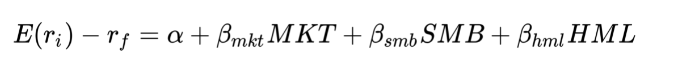

In [6]:

stock_returns = TSLA['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = "Month_Rtn"
ff_data = ff3_monthly.merge(stock_returns,on='Date')

In [7]:
X = ff_data[['Mkt-RF', 'SMB', 'HML']]
y = ff_data['Month_Rtn'] - ff_data['RF']
'Add Constant to X'
X.insert(loc=0,value=np.ones(len(X)),column='I')
N = X.shape[1]

'Linear Regression of Y: T x 1 on'
'Regressors X: T x N'
invXX = np.linalg.inv(X.transpose()@X)
'OLS estimates for coefficients: X x 1'
beta_hat = invXX@X.transpose()@y


#### Calculating the Intercept, coefficent of MKT_EXCESS, SML and HML

In [8]:
rf = ff_data['RF'].mean()
market_premium = ff3_monthly['Mkt-RF'].mean()
size_premium = ff3_monthly['SMB'].mean()
value_premium = ff3_monthly['HML'].mean()

intercept, b1, b2, b3 = beta_hat



In [9]:
print('------------------------\n')
print('Intercept ->',intercept)
print('MKT_EXCESS ->',b1)
print('SMB ->',b2)
print('HML ->',b3)

------------------------

Intercept -> 0.036793433008481584
MKT_EXCESS -> 2.3110519313202325
SMB -> -0.4187444814633089
HML -> -0.9269830945528543


#### Combining all the parameters into one functions to calculate the portfolio returns against the Fama French Model

In [10]:
expected_monthly_return = rf + b1 * market_premium + b2 * size_premium + b3 * value_premium 
expected_yearly_return = expected_monthly_return * 12
print("Expected yearly return: " + str(expected_yearly_return))

Expected yearly return: 0.15679859424062975


### Suggestion : Add momentum factor

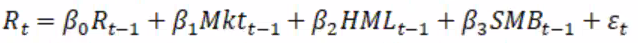

### ARIMA Model ( Autoregressive Integrated Moving Average Model)

In [11]:
tsla = yf.Ticker("TSLA")

# To get stock info
tsla.info

# get historical market data as df
hist = tsla.history(period="max")

# Save dataframe as CSV file
hist.to_csv('TSLA.CSV')

# Read data in to dataframes
tsla = pd.read_csv('TSLA.CSV')

# Change date column to datetime type
tsla['Date'] = pd.to_datetime(tsla['Date'])

tsla.dropna(inplace=True)


<AxesSubplot:>

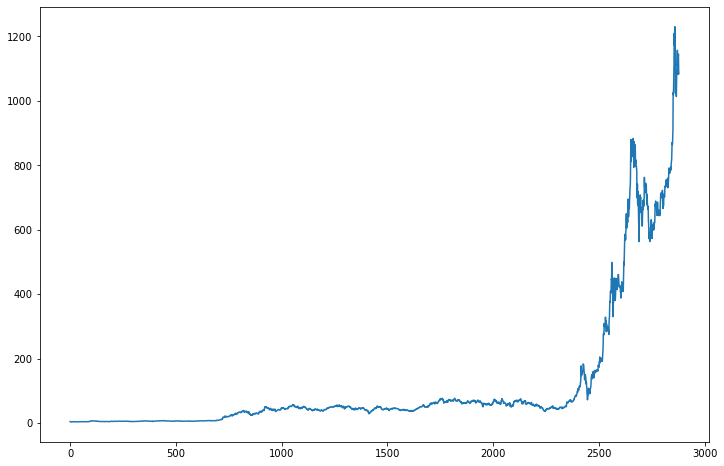

In [12]:
tsla['Close'].plot(figsize=(12,8))

In [13]:
series = tsla['Close']

# Create train data set
train_split_date = '2015-12-31'
train_split_index = np.where(tsla.Date == train_split_date)[0][0]
x_train = tsla.loc[tsla['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2018-01-02'
test_split_index = np.where(tsla.Date == test_split_date)[0][0]
x_test = tsla.loc[tsla['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = tsla.loc[(tsla['Date'] < test_split_date) & (tsla['Date'] > train_split_date)]['Close']

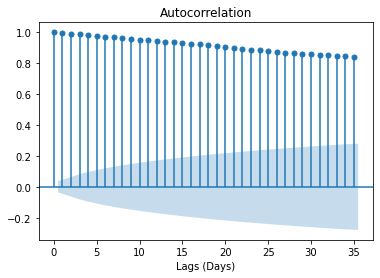

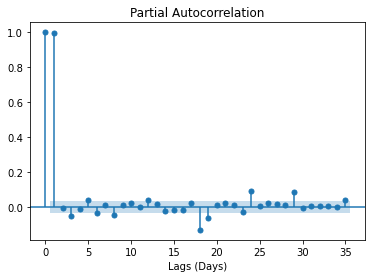

In [14]:
# Plot of autocorrelation

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(series)
plt.xlabel('Lags (Days)')
plt.show()

## Plot of partial autocorrelation

plot_pacf(series)
plt.xlabel('Lags (Days)')
plt.show()

### When plotting the value of the ACF for increasing lags, the values tend to degrade to zero quickly for stationary time series , while for non-stationary data the degradation will happen more slowly hence we can conclude that the time series is not stationary

### We Also Perform Dickey-Fuller test

In [15]:
 #Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(series, autolag='AIC', maxlag = 20 )
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
print(dfoutput)

Results of Dickey-Fuller Test:
p-value = 1.0000. The series is likely non-stationary.
Test Statistic                    3.296788
p-value                           1.000000
#Lags Used                       19.000000
Number of Observations Used    2859.000000
Critical Value (1%)              -3.432639
Critical Value (5%)              -2.862551
Critical Value (10%)             -2.567308
dtype: float64


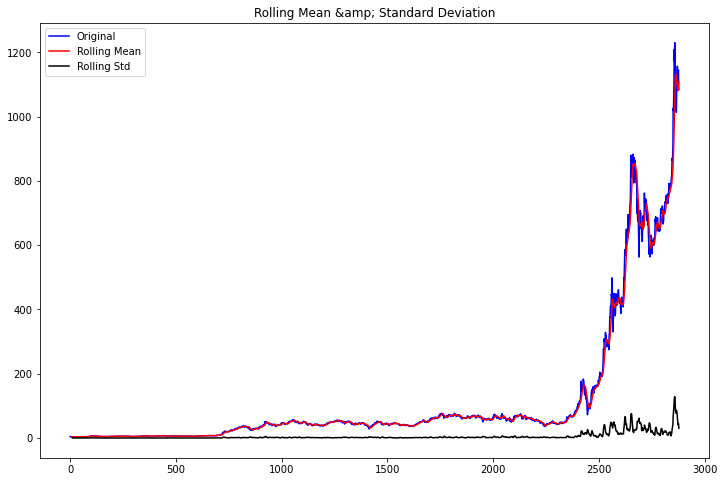

0      2010-06-29
1      2010-06-30
2      2010-07-01
3      2010-07-02
4      2010-07-06
          ...    
2874   2021-11-26
2875   2021-11-29
2876   2021-11-30
2877   2021-12-01
2878   2021-12-02
Name: Date, Length: 2879, dtype: datetime64[ns]


In [97]:
#Determing rolling statistics
rolmean = series.rolling(12).mean()
rolstd = series.rolling(12).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean &amp; Standard Deviation')
plt.show()


In [17]:
#Convert our non-stationary data to stationary data using the differencing method
new_series= series.diff()
new_series.dropna(inplace=True)
#test_stationarity(new_series)

In [18]:
#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(new_series, autolag='AIC', maxlag = 20 )
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
print(dfoutput)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.035182e+01
p-value                        2.525119e-18
#Lags Used                     2.000000e+01
Number of Observations Used    2.857000e+03
Critical Value (1%)           -3.432641e+00
Critical Value (5%)           -2.862552e+00
Critical Value (10%)          -2.567309e+00
dtype: float64


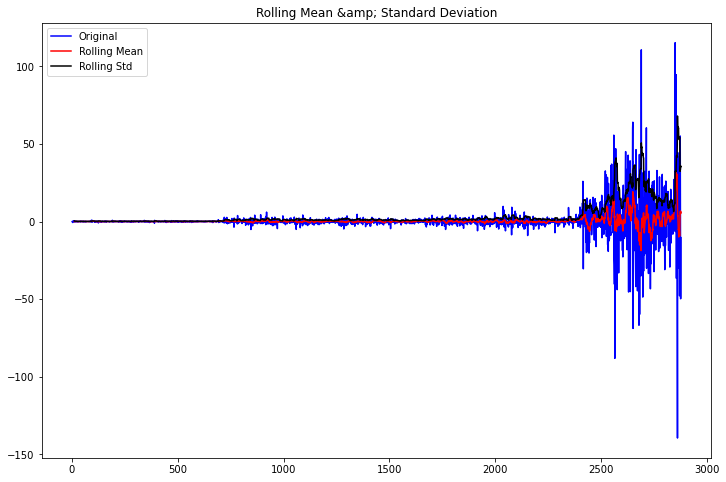

In [19]:
#Determing rolling statistics
rolmean = new_series.rolling(12).mean()
rolstd = new_series.rolling(12).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(new_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean &amp; Standard Deviation')
plt.show()

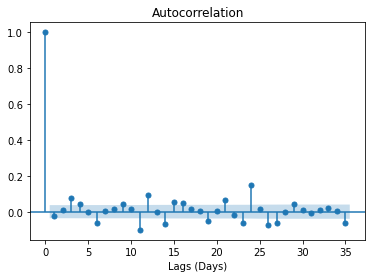

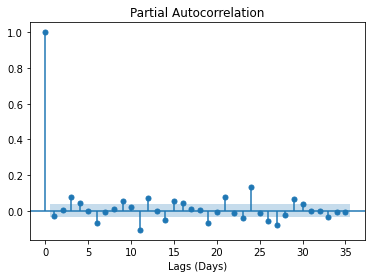

In [20]:
# Plot of autocorrelation

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(new_series)
plt.xlabel('Lags (Days)')
plt.show()

## Plot of partial autocorrelation

plot_pacf(new_series)
plt.xlabel('Lags (Days)')
plt.show()

In [21]:
from statsmodels.tsa.arima_model import ARIMA


### Selecting the best p, d, q parameters for the ARIMA model by using the AIC (Akaike Information Critera )

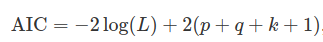

In [22]:
import itertools
p=d=q=range(0,3)
pdq =list(itertools.product(p,d,q))

In [23]:

import warnings
warnings.filterwarnings("ignore")
AIC={}
for i in pdq:
    try:
        tsla_arima=ARIMA(x_train,order=(i))
        model_fit=tsla_arima.fit()
        print('AIC value -> ',model_fit.aic)
        print("(p,d,q) -> ",i)
        print('------------------------\n')
        AIC[model_fit.aic]=i
    except:
        continue

AIC value ->  12079.908181671082
(p,d,q) ->  (0, 0, 0)
------------------------

AIC value ->  10247.266521120002
(p,d,q) ->  (0, 0, 1)
------------------------

AIC value ->  8762.88754844423
(p,d,q) ->  (0, 0, 2)
------------------------

AIC value ->  3483.6817028572705
(p,d,q) ->  (0, 1, 0)
------------------------

AIC value ->  3485.5946628900406
(p,d,q) ->  (0, 1, 1)
------------------------

AIC value ->  3487.005931737149
(p,d,q) ->  (0, 1, 2)
------------------------

AIC value ->  4431.980758096913
(p,d,q) ->  (0, 2, 0)
------------------------

AIC value ->  3491.2512338585216
(p,d,q) ->  (0, 2, 1)
------------------------

AIC value ->  3493.150278292095
(p,d,q) ->  (0, 2, 2)
------------------------

AIC value ->  3495.861026967308
(p,d,q) ->  (1, 0, 0)
------------------------

AIC value ->  3497.728866521523
(p,d,q) ->  (1, 0, 1)
------------------------

AIC value ->  3499.253684325634
(p,d,q) ->  (1, 0, 2)
------------------------

AIC value ->  3485.598105161499
(p,d

#### Finding the best parameter with minimum AIC value

In [24]:
print('Best parameters p, d and q ->',AIC[min(AIC.keys())])


Best parameters p, d and q -> (0, 1, 0)


In [25]:
### Fitting the model
tsla_arima = ARIMA(x_train, order=(0,1,0))
tsla_arima_fit = tsla_arima.fit(disp=0)
print(tsla_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1387
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1739.841
Method:                           css   S.D. of innovations              0.848
Date:                Thu, 02 Dec 2021   AIC                           3483.682
Time:                        17:25:44   BIC                           3494.151
Sample:                             1   HQIC                          3487.597
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0312      0.023      1.368      0.171      -0.013       0.076


In [26]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
MAE_error = mean_squared_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

# %store model_predictions

Testing Mean Squared Error is 241.19017703223864


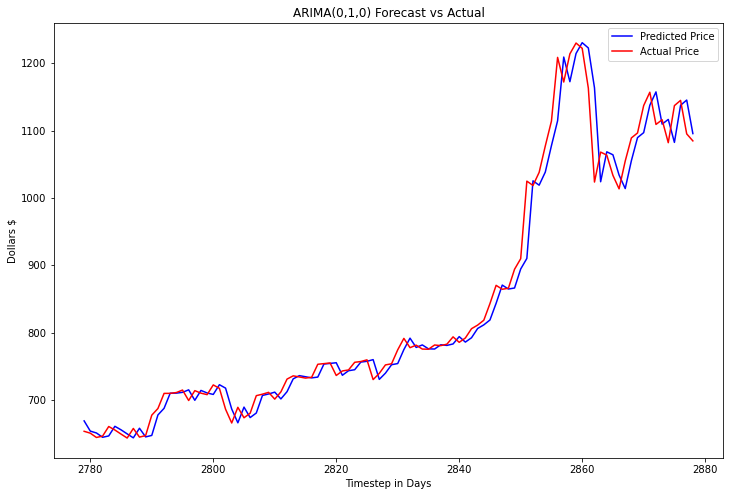

In [27]:
# Plot our predictions against the actual values for a visual comparison.
fig = plt.figure(figsize=(12, 8))
plt.plot(x_test.index[-100:], model_predictions[-100:], color='blue',label='Predicted Price')
plt.plot(x_test.index[-100:], x_test[-100:], color='red', label='Actual Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(0,1,0) Forecast vs Actual')
plt.legend()

plt.savefig('TSLA_ARIMA_Predict.jpeg')
plt.show()


### K - means Clustering

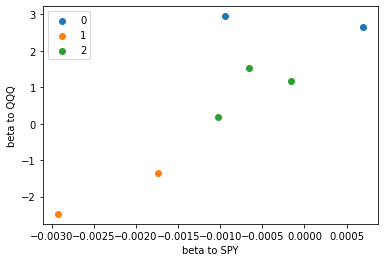

               0
Cluster index   
TSLA           1
GM             0
F              0
HMC            2
TM             2
RACE           2
NIO            1


In [28]:
#Clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as pyplot

# Stock Selection 
LIST = ['TSLA','GM','F','HMC','TM','RACE','NIO']
start_date = datetime(2021,1,1)
end_date = datetime(2021,8,31)
FACTOR = ['SPY', 'QQQ']        
N = len(LIST)
PORTFOLIO = pd.DataFrame(columns = LIST) 
for n in range(0, N):
    PRICE = DataReader(LIST[n], 'yahoo', start_date,end_date)
    RETURN = np.diff(np.log(PRICE['Adj Close'].values))
    PORTFOLIO[LIST[n]] = RETURN
    # First Pass - TIME SERIES
    T = PORTFOLIO.shape[0]
    SPY = DataReader(FACTOR[0], 'yahoo', start_date,end_date)
    F1 = np.diff(np.log(SPY['Adj Close'].values))
    QQQ = DataReader(FACTOR[1], 'yahoo', start_date,end_date)
    F2 = np.diff(np.log(QQQ['Adj Close'].values))
    X = np.asmatrix(np.column_stack([np.ones((T,1)), F1, F2]))
    K = X.shape[1]
beta = np.zeros([K,N])
Y = np.zeros([T,N]) 
for n in range(0, N):
    Y[:,n] = PORTFOLIO[LIST[n]].values
    #Linear Regression of Y: T x 1 on 
    # Regressors X: T x N
    invXX = np.linalg.inv(X.transpose()@X)
    #OLS estimator beta: N x 1'
    beta[:,n] = invXX@X.transpose()@Y[:,n]


X = beta.transpose()
# K Mean Clustering
from sklearn.cluster import KMeans
# define the model
model = KMeans(n_clusters=3)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
	# create scatter of these samples


	plt.scatter(X[row_ix, 0], X[row_ix, 1],label=cluster)

# show the plot
pyplot.xlabel("beta to SPY")
pyplot.ylabel("beta to QQQ")
pyplot.legend()
pyplot.show()


df2 = pd.DataFrame(yhat,LIST)
index = df2.index
index.name = "Cluster index"
print(df2)

### Agglomerative Clustering

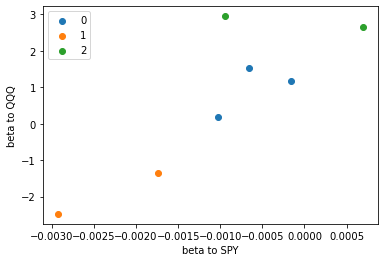

               0
Cluster index   
TSLA           1
GM             2
F              2
HMC            0
TM             0
RACE           0
NIO            1


In [29]:

# define the model
model = AgglomerativeClustering(n_clusters=3)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1],label=cluster)
# show the plot
pyplot.xlabel("beta to SPY")
pyplot.ylabel("beta to QQQ")
pyplot.legend()
pyplot.show()        
# print(yhat)

df1 = pd.DataFrame(yhat,LIST)
index = df1.index
index.name = "Cluster index"
print(df1)



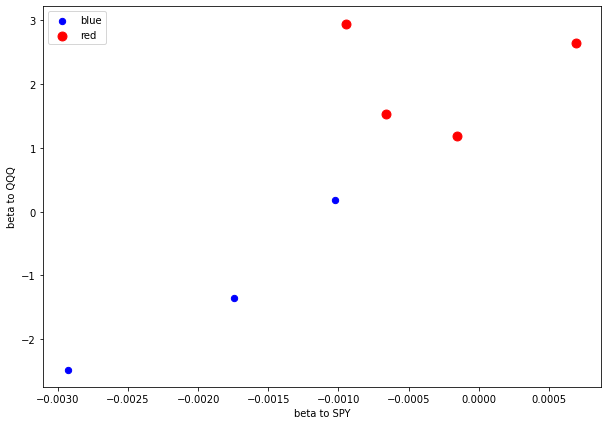

In [30]:
#Isolation Forest
from sklearn.ensemble import IsolationForest

from datetime import datetime

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as ss
from pandas_datareader import DataReader

# Stock Selection 
LIST = ['TSLA','GM','F','HMC','TM','RACE','NIO']
start_date = datetime(2021,1,1)
end_date = datetime(2021,8,31)
FACTOR = ['SPY', 'QQQ']        
N = len(LIST)
PORTFOLIO = pd.DataFrame(columns = LIST) 
for n in range(0, N):
    PRICE = DataReader(LIST[n], 'yahoo', start_date,end_date)
    RETURN = np.diff(np.log(PRICE['Adj Close'].values))
    PORTFOLIO[LIST[n]] = RETURN
 
 # First Pass - TIME SERIES
    T = PORTFOLIO.shape[0]
    SPY = DataReader(FACTOR[0], 'yahoo', start_date,end_date)
    F1 = np.diff(np.log(SPY['Adj Close'].values))
    QQQ = DataReader(FACTOR[1], 'yahoo', start_date,end_date)
    F2 = np.diff(np.log(QQQ['Adj Close'].values))
    X = np.asmatrix(np.column_stack([np.ones((T,1)), F1, F2]))
    K = X.shape[1]
    
beta = np.zeros([K,N])
Y = np.zeros([T,N]) 
for n in range(0, N):
    Y[:,n] = PORTFOLIO[LIST[n]].values
    #Linear Regression of Y: T x 1 on 
    # Regressors X: T x N
    invXX = np.linalg.inv(X.transpose()@X)
    #OLS estimator beta: N x 1'
    beta[:,n] = invXX@X.transpose()@Y[:,n]


fig = plt.figure(figsize = (10, 7))    
plt.scatter(beta[0,:], beta[1,:], color = 'b', s = 40,label='blue')
plt.xlabel('beta to SPY')
plt.ylabel('beta to QQQ')
plt.scatter(beta[0,:][beta[1,:]>1], beta[1,:][beta[1,:]>1], color = 'r', s= 80,label='red')
plt.legend()
plt.show()

model=IsolationForest(n_estimators=1000, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

model.fit(beta.transpose())
scores = model.decision_function(beta.transpose())
pred = model.predict(beta.transpose())

In [31]:
df3 = pd.DataFrame(LIST,pred)
df3

,0
1,TSLA
1,GM
1,F
1,HMC
1,TM
1,RACE
-1,NIO


In [33]:
# Import libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

#from config import ACCOUNT_NUMBER, ACCOUNT_PASSWORD, CONSUMER_ID, REDIRECT_URI

In [ ]:
#pip install config

In [92]:
days_out = 30

# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
tsla['Signal_Flag'] = tsla['Close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 50 rows
tsla.head(50)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Signal_Flag
0,2010-06-29,3.800,5.000,3.508,4.778,93831500,0,0.0,NaN
1,2010-06-30,5.158,6.084,4.660,4.766,85935500,0,0.0,NaN
2,2010-07-01,5.000,5.184,4.054,4.392,41094000,0,0.0,NaN
3,2010-07-02,4.600,4.620,3.742,3.840,25699000,0,0.0,NaN
4,2010-07-06,4.000,4.000,3.166,3.222,34334500,0,0.0,NaN
5,2010-07-07,3.280,3.326,2.996,3.160,34608500,0,0.0,NaN
6,2010-07-08,3.228,3.504,3.114,3.492,38557000,0,0.0,NaN
7,2010-07-09,3.516,3.580,3.310,3.480,20253000,0,0.0,NaN
8,2010-07-12,3.590,3.614,3.400,3.410,11012500,0,0.0,NaN
9,2010-07-13,3.478,3.728,3.380,3.628,13400500,0,0.0,NaN


In [98]:
tsla.sort_values(by = ['Date'], inplace = True)

# calculate the change in price
tsla['change_in_price'] = tsla['Close'].diff()

print(tsla['Date'])

0      2010-06-29
1      2010-06-30
2      2010-07-01
3      2010-07-02
4      2010-07-06
          ...    
2874   2021-11-26
2875   2021-11-29
2876   2021-11-30
2877   2021-12-01
2878   2021-12-02
Name: Date, Length: 2879, dtype: datetime64[ns]


In [99]:


# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = tsla[['change_in_price']].copy(), tsla[['change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
tsla['down_days'] = down_df['change_in_price']
tsla['up_days'] = up_df['change_in_price']
tsla['RSI'] = relative_strength_index

# Display the head.
tsla.head(30)




,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Signal_Flag,change_in_price,down_days,up_days,RSI
0,2010-06-29,3.800,5.000,3.508,4.778,93831500,0,0.0,NaN,NaN,NaN,NaN,NaN
1,2010-06-30,5.158,6.084,4.660,4.766,85935500,0,0.0,NaN,-0.012,0.012,0.000,0.000000
2,2010-07-01,5.000,5.184,4.054,4.392,41094000,0,0.0,NaN,-0.374,0.374,0.000,0.000000
3,2010-07-02,4.600,4.620,3.742,3.840,25699000,0,0.0,NaN,-0.552,0.552,0.000,0.000000
4,2010-07-06,4.000,4.000,3.166,3.222,34334500,0,0.0,NaN,-0.618,0.618,0.000,0.000000
5,2010-07-07,3.280,3.326,2.996,3.160,34608500,0,0.0,NaN,-0.062,0.062,0.000,0.000000
6,2010-07-08,3.228,3.504,3.114,3.492,38557000,0,0.0,NaN,0.332,0.000,0.332,23.279989
7,2010-07-09,3.516,3.580,3.310,3.480,20253000,0,0.0,NaN,-0.012,0.012,0.000,23.056136
8,2010-07-12,3.590,3.614,3.400,3.410,11012500,0,0.0,NaN,-0.070,0.070,0.000,21.654637
9,2010-07-13,3.478,3.728,3.380,3.628,13400500,0,0.0,NaN,0.218,0.000,0.218,35.699759


In [102]:


# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = tsla[['Low']].copy(), tsla[['High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((tsla['Close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
tsla['low_14'] = low_14
tsla['high_14'] = high_14
tsla['k_percent'] = k_percent

# Display the head.
tsla.head(30)



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
0,2010-06-29,3.800,5.000,3.508,4.778,93831500,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-06-30,5.158,6.084,4.660,4.766,85935500,0,0.0,NaN,-0.012,0.012,0.000,0.000000,NaN,NaN,NaN
2,2010-07-01,5.000,5.184,4.054,4.392,41094000,0,0.0,NaN,-0.374,0.374,0.000,0.000000,NaN,NaN,NaN
3,2010-07-02,4.600,4.620,3.742,3.840,25699000,0,0.0,NaN,-0.552,0.552,0.000,0.000000,NaN,NaN,NaN
4,2010-07-06,4.000,4.000,3.166,3.222,34334500,0,0.0,NaN,-0.618,0.618,0.000,0.000000,NaN,NaN,NaN
5,2010-07-07,3.280,3.326,2.996,3.160,34608500,0,0.0,NaN,-0.062,0.062,0.000,0.000000,NaN,NaN,NaN
6,2010-07-08,3.228,3.504,3.114,3.492,38557000,0,0.0,NaN,0.332,0.000,0.332,23.279989,NaN,NaN,NaN
7,2010-07-09,3.516,3.580,3.310,3.480,20253000,0,0.0,NaN,-0.012,0.012,0.000,23.056136,NaN,NaN,NaN
8,2010-07-12,3.590,3.614,3.400,3.410,11012500,0,0.0,NaN,-0.070,0.070,0.000,21.654637,NaN,NaN,NaN
9,2010-07-13,3.478,3.728,3.380,3.628,13400500,0,0.0,NaN,0.218,0.000,0.218,35.699759,NaN,NaN,NaN


In [103]:


# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = tsla[['Low']].copy(), tsla[['High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - tsla['Close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
tsla['r_percent'] = r_percent

# Display the head.
tsla.head(30)



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,2010-06-29,3.800,5.000,3.508,4.778,93831500,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-06-30,5.158,6.084,4.660,4.766,85935500,0,0.0,NaN,-0.012,0.012,0.000,0.000000,NaN,NaN,NaN,NaN
2,2010-07-01,5.000,5.184,4.054,4.392,41094000,0,0.0,NaN,-0.374,0.374,0.000,0.000000,NaN,NaN,NaN,NaN
3,2010-07-02,4.600,4.620,3.742,3.840,25699000,0,0.0,NaN,-0.552,0.552,0.000,0.000000,NaN,NaN,NaN,NaN
4,2010-07-06,4.000,4.000,3.166,3.222,34334500,0,0.0,NaN,-0.618,0.618,0.000,0.000000,NaN,NaN,NaN,NaN
5,2010-07-07,3.280,3.326,2.996,3.160,34608500,0,0.0,NaN,-0.062,0.062,0.000,0.000000,NaN,NaN,NaN,NaN
6,2010-07-08,3.228,3.504,3.114,3.492,38557000,0,0.0,NaN,0.332,0.000,0.332,23.279989,NaN,NaN,NaN,NaN
7,2010-07-09,3.516,3.580,3.310,3.480,20253000,0,0.0,NaN,-0.012,0.012,0.000,23.056136,NaN,NaN,NaN,NaN
8,2010-07-12,3.590,3.614,3.400,3.410,11012500,0,0.0,NaN,-0.070,0.070,0.000,21.654637,NaN,NaN,NaN,NaN
9,2010-07-13,3.478,3.728,3.380,3.628,13400500,0,0.0,NaN,0.218,0.000,0.218,35.699759,NaN,NaN,NaN,NaN


In [106]:


# Calculate the MACD
ema_26 = tsla['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = tsla['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
tsla['MACD'] = macd
tsla['MACD_EMA'] = ema_9_macd

# Print the head.
tsla.head(30)



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,2010-06-29,3.800,5.000,3.508,4.778,93831500,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2010-06-30,5.158,6.084,4.660,4.766,85935500,0,0.0,NaN,-0.012,0.012,0.000,0.000000,NaN,NaN,NaN,NaN,-0.000269,-0.000150
2,2010-07-01,5.000,5.184,4.054,4.392,41094000,0,0.0,NaN,-0.374,0.374,0.000,0.000000,NaN,NaN,NaN,NaN,-0.011941,-0.004982
3,2010-07-02,4.600,4.620,3.742,3.840,25699000,0,0.0,NaN,-0.552,0.552,0.000,0.000000,NaN,NaN,NaN,NaN,-0.036886,-0.015790
4,2010-07-06,4.000,4.000,3.166,3.222,34334500,0,0.0,NaN,-0.618,0.618,0.000,0.000000,NaN,NaN,NaN,NaN,-0.074256,-0.033182
5,2010-07-07,3.280,3.326,2.996,3.160,34608500,0,0.0,NaN,-0.062,0.062,0.000,0.000000,NaN,NaN,NaN,NaN,-0.097976,-0.050745
6,2010-07-08,3.228,3.504,3.114,3.492,38557000,0,0.0,NaN,0.332,0.000,0.332,23.279989,NaN,NaN,NaN,NaN,-0.096460,-0.062314
7,2010-07-09,3.516,3.580,3.310,3.480,20253000,0,0.0,NaN,-0.012,0.012,0.000,23.056136,NaN,NaN,NaN,NaN,-0.094464,-0.070040
8,2010-07-12,3.590,3.614,3.400,3.410,11012500,0,0.0,NaN,-0.070,0.070,0.000,21.654637,NaN,NaN,NaN,NaN,-0.095117,-0.075833
9,2010-07-13,3.478,3.728,3.380,3.628,13400500,0,0.0,NaN,0.218,0.000,0.218,35.699759,NaN,NaN,NaN,NaN,-0.082967,-0.077432


In [109]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
tsla['Price_Rate_Of_Change'] = tsla['Close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
tsla.head(30)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,2010-06-29,3.800,5.000,3.508,4.778,93831500,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,2010-06-30,5.158,6.084,4.660,4.766,85935500,0,0.0,NaN,-0.012,0.012,0.000,0.000000,NaN,NaN,NaN,NaN,-0.000269,-0.000150,NaN
2,2010-07-01,5.000,5.184,4.054,4.392,41094000,0,0.0,NaN,-0.374,0.374,0.000,0.000000,NaN,NaN,NaN,NaN,-0.011941,-0.004982,NaN
3,2010-07-02,4.600,4.620,3.742,3.840,25699000,0,0.0,NaN,-0.552,0.552,0.000,0.000000,NaN,NaN,NaN,NaN,-0.036886,-0.015790,NaN
4,2010-07-06,4.000,4.000,3.166,3.222,34334500,0,0.0,NaN,-0.618,0.618,0.000,0.000000,NaN,NaN,NaN,NaN,-0.074256,-0.033182,NaN
5,2010-07-07,3.280,3.326,2.996,3.160,34608500,0,0.0,NaN,-0.062,0.062,0.000,0.000000,NaN,NaN,NaN,NaN,-0.097976,-0.050745,NaN
6,2010-07-08,3.228,3.504,3.114,3.492,38557000,0,0.0,NaN,0.332,0.000,0.332,23.279989,NaN,NaN,NaN,NaN,-0.096460,-0.062314,NaN
7,2010-07-09,3.516,3.580,3.310,3.480,20253000,0,0.0,NaN,-0.012,0.012,0.000,23.056136,NaN,NaN,NaN,NaN,-0.094464,-0.070040,NaN
8,2010-07-12,3.590,3.614,3.400,3.410,11012500,0,0.0,NaN,-0.070,0.070,0.000,21.654637,NaN,NaN,NaN,NaN,-0.095117,-0.075833,NaN
9,2010-07-13,3.478,3.728,3.380,3.628,13400500,0,0.0,NaN,0.218,0.000,0.218,35.699759,NaN,NaN,NaN,NaN,-0.082967,-0.077432,-0.240686


In [117]:
def obv(group):

    # Grab the volume and close column.
    volume = tsla['Volume']
    change = tsla['Close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = tsla.apply(obv)

# add to the data frame, but drop the old index, before adding it.
#tsla['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

# display the data frame.
tsla.head(30)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Signal_Flag,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,2010-06-29,3.800,5.000,3.508,4.778,93831500,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,2010-06-30,5.158,6.084,4.660,4.766,85935500,0,0.0,NaN,-0.012,0.012,0.000,0.000000,NaN,NaN,NaN,NaN,-0.000269,-0.000150,NaN
2,2010-07-01,5.000,5.184,4.054,4.392,41094000,0,0.0,NaN,-0.374,0.374,0.000,0.000000,NaN,NaN,NaN,NaN,-0.011941,-0.004982,NaN
3,2010-07-02,4.600,4.620,3.742,3.840,25699000,0,0.0,NaN,-0.552,0.552,0.000,0.000000,NaN,NaN,NaN,NaN,-0.036886,-0.015790,NaN
4,2010-07-06,4.000,4.000,3.166,3.222,34334500,0,0.0,NaN,-0.618,0.618,0.000,0.000000,NaN,NaN,NaN,NaN,-0.074256,-0.033182,NaN
5,2010-07-07,3.280,3.326,2.996,3.160,34608500,0,0.0,NaN,-0.062,0.062,0.000,0.000000,NaN,NaN,NaN,NaN,-0.097976,-0.050745,NaN
6,2010-07-08,3.228,3.504,3.114,3.492,38557000,0,0.0,NaN,0.332,0.000,0.332,23.279989,NaN,NaN,NaN,NaN,-0.096460,-0.062314,NaN
7,2010-07-09,3.516,3.580,3.310,3.480,20253000,0,0.0,NaN,-0.012,0.012,0.000,23.056136,NaN,NaN,NaN,NaN,-0.094464,-0.070040,NaN
8,2010-07-12,3.590,3.614,3.400,3.410,11012500,0,0.0,NaN,-0.070,0.070,0.000,21.654637,NaN,NaN,NaN,NaN,-0.095117,-0.075833,NaN
9,2010-07-13,3.478,3.728,3.380,3.628,13400500,0,0.0,NaN,0.218,0.000,0.218,35.699759,NaN,NaN,NaN,NaN,-0.082967,-0.077432,-0.240686


In [119]:


# Create a column we wish to predict
'''
    In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
    In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
'''

# Group by the `Symbol` column, then grab the `Close` column.
close_groups = tsla['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
tsla['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
tsla.loc[tsla['Prediction'] == 0.0] = 1.0

# print the head
tsla.head(50)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Signal_Flag,change_in_price,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
0,2010-06-29 00:00:00,3.800,5.000,3.508,4.778,93831500,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
1,2010-06-30 00:00:00,5.158,6.084,4.660,4.766,85935500,0,0.0,NaN,-0.012,...,0.000,0.000000,NaN,NaN,NaN,NaN,-0.000269,-0.000150,NaN,-1.0
2,2010-07-01 00:00:00,5.000,5.184,4.054,4.392,41094000,0,0.0,NaN,-0.374,...,0.000,0.000000,NaN,NaN,NaN,NaN,-0.011941,-0.004982,NaN,-1.0
3,2010-07-02 00:00:00,4.600,4.620,3.742,3.840,25699000,0,0.0,NaN,-0.552,...,0.000,0.000000,NaN,NaN,NaN,NaN,-0.036886,-0.015790,NaN,-1.0
4,2010-07-06 00:00:00,4.000,4.000,3.166,3.222,34334500,0,0.0,NaN,-0.618,...,0.000,0.000000,NaN,NaN,NaN,NaN,-0.074256,-0.033182,NaN,-1.0
5,2010-07-07 00:00:00,3.280,3.326,2.996,3.160,34608500,0,0.0,NaN,-0.062,...,0.000,0.000000,NaN,NaN,NaN,NaN,-0.097976,-0.050745,NaN,-1.0
6,2010-07-08 00:00:00,3.228,3.504,3.114,3.492,38557000,0,0.0,NaN,0.332,...,0.332,23.279989,NaN,NaN,NaN,NaN,-0.096460,-0.062314,NaN,1.0
7,2010-07-09 00:00:00,3.516,3.580,3.310,3.480,20253000,0,0.0,NaN,-0.012,...,0.000,23.056136,NaN,NaN,NaN,NaN,-0.094464,-0.070040,NaN,-1.0
8,2010-07-12 00:00:00,3.590,3.614,3.400,3.410,11012500,0,0.0,NaN,-0.070,...,0.000,21.654637,NaN,NaN,NaN,NaN,-0.095117,-0.075833,NaN,-1.0
9,2010-07-13 00:00:00,3.478,3.728,3.380,3.628,13400500,0,0.0,NaN,0.218,...,0.218,35.699759,NaN,NaN,NaN,NaN,-0.082967,-0.077432,-0.240686,1.0


In [121]:


# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(tsla.shape[0], tsla.shape[1]))

# Any row that has a `NaN` value will be dropped.
tsla = tsla.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(tsla.shape[0], tsla.shape[1]))

# Print the head.
tsla.head()


Before NaN Drop we have 2879 rows and 21 columns
After NaN Drop we have 2849 rows and 21 columns


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Signal_Flag,change_in_price,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
30,2010-08-11 00:00:00,3.738,3.776,3.570,3.580,3988000,0,0.0,-1.0,-0.226,...,0.000,26.931607,3.570,4.436,1.154733,-98.845267,-0.034902,0.019952,-0.120393,-1.0
31,2010-08-12 00:00:00,3.560,3.580,3.478,3.520,3455000,0,0.0,-1.0,-0.060,...,0.000,25.217391,3.478,4.436,4.384140,-95.615860,-0.064834,0.002982,-0.117352,-1.0
32,2010-08-13 00:00:00,3.636,3.690,3.532,3.664,3170000,0,0.0,-1.0,0.144,...,0.144,36.423603,3.478,4.436,19.415461,-80.584539,-0.076816,-0.012988,-0.124283,1.0
33,2010-08-16 00:00:00,3.690,3.760,3.652,3.756,2429000,0,0.0,-1.0,0.092,...,0.092,42.748037,3.478,4.436,29.018803,-70.981197,-0.078448,-0.026087,-0.144419,1.0
34,2010-08-17 00:00:00,3.792,3.880,3.756,3.830,2239500,0,0.0,1.0,0.074,...,0.074,47.587037,3.478,4.436,36.743217,-63.256783,-0.073282,-0.035530,-0.099247,1.0


In [123]:
# Grab our X & Y Columns.
X_Cols = tsla[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD']]
Y_Cols = tsla['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [124]:
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  69.00420757363254
